In [1]:
import numpy as np 
import pandas as pd
import os 

if 'src' in os.getcwd():
    os.chdir('..')


from helpers.data_handler import Dataset, DatasetPreprocessor

dataset = Dataset('fico')
dataset_preprocessor = DatasetPreprocessor(
    dataset=dataset,
    split=0.8,
    random_state=1,
    one_hot=True,
)

X_train_pd, X_test_pd, y_train, y_test = dataset_preprocessor.get_data()

# Convert to numpy
X_train, X_test = [x.to_numpy() for x in (X_train_pd, X_test_pd)]
print(f'Shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

Shapes: X_train: (2001, 23), X_test: (501, 23), y_train: (2001,), y_test: (501,)


In [2]:
# Calculate class ratios
class_ratios = np.unique(y_train, return_counts=True)
print(f'Class ratios: {class_ratios}')
minority_idx = np.argmin(class_ratios[1])
print(f'Minority class: {class_ratios[0][minority_idx]}')

Class ratios: (array([0, 1]), array([1248,  753]))
Minority class: 1


In [3]:
# Calculate the distance to nth nearest neighbor for each sample in the minority class
from sklearn.neighbors import NearestNeighbors

n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(X_train)

# Get the indices of the minority class
minority_indices = np.where(y_train == class_ratios[0][minority_idx])[0]
print(f'Number of samples in the minority class: {len(minority_indices)}')

# Get the distances to the nth nearest neighbor
distances = []
for idx in minority_indices:
    distances.append(nn.kneighbors([X_train[idx]], n_neighbors=n_neighbors)[0][0][-1])
    
distances = np.array(distances)
average = np.mean(distances)
std = np.std(distances)
print(f'Average distance to {n_neighbors} nearest neighbors: {average:.2f} +/- {std:.2f}')

Number of samples in the minority class: 753
Average distance to 5 nearest neighbors: 0.47 +/- 0.11


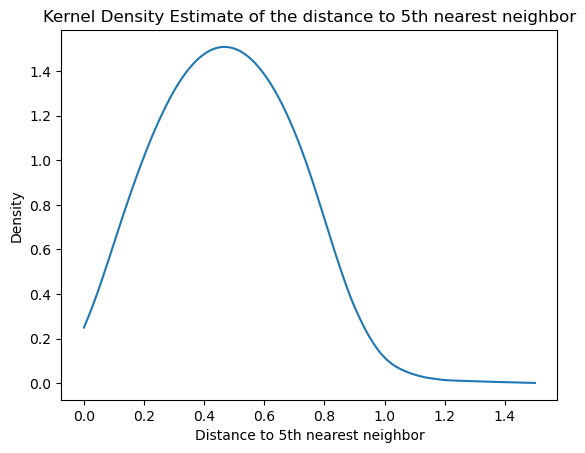

In [4]:
# Now we will create a kernel density estimate using Epanechnikov kernel with the bandwidth calculated as the average distance to the nth nearest neighbor
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

kde = KernelDensity(kernel='epanechnikov', bandwidth=average)
kde.fit(distances.reshape(-1, 1))

# Plot the KDE
x = np.linspace(0, 1.5, 1000)
log_dens = kde.score_samples(x.reshape(-1, 1))

plt.plot(x, np.exp(log_dens))
plt.xlabel('Distance to 5th nearest neighbor')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of the distance to 5th nearest neighbor')
plt.show()


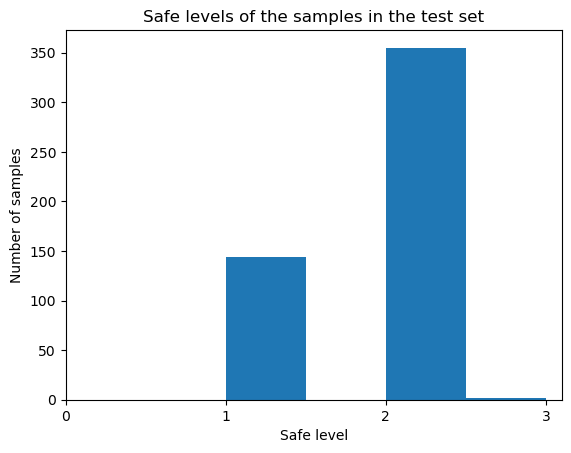

In [5]:
# Now, we want to classify samples in the test set 
# We will weight neigbors' votes by the distance to the nth nearest neighbor (using already calculated KDE)
from sklearn.metrics import accuracy_score

def weighted_knn(X_train, y_train, X_test, y_test, kde, class_idx, n_neighbors=1000):
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(X_train)
    
    # Get the indices of the class_idx class
    class_indices = np.where(y_train == class_ratios[0][class_idx])[0]
    
    # Get the distances to the nth nearest neighbor
    distances = []
    for idx in class_indices:
        distances.append(nn.kneighbors([X_train[idx]], n_neighbors=n_neighbors)[0][0][-1])
    
    distances = np.array(distances)
    weights = np.exp(kde.score_samples(distances.reshape(-1, 1)))
    
    # Normalize the weights
    weights /= np.sum(weights)
    
    # Now, we will classify the samples in the test set
    predictions = []
    for sample in X_test:
        distances = nn.kneighbors([sample], n_neighbors=n_neighbors)[0][0]
        weights = np.exp(kde.score_samples(distances.reshape(-1, 1)))
        weights /= np.sum(weights)
        
        # Get the labels of the neighbors
        neighbors_labels = y_train[nn.kneighbors([sample], n_neighbors=n_neighbors)[1][0]]
        
        # Weight the neighbors' votes
        prediction = np.sum(neighbors_labels * weights)
        predictions.append(prediction)
        
    if class_idx == 0:
        predictions = 1 - np.array(predictions)
    
    return np.array(predictions)

def predictions_to_safe_levels(predictions, thresholds=[0.7,0.3,0.1]):
    safe_levels = np.zeros_like(predictions)
    for i, pred in enumerate(predictions):
        if pred > thresholds[0]:
            safe_levels[i] = 3
        elif pred > thresholds[1]:
            safe_levels[i] = 2
        elif pred > thresholds[2]:
            safe_levels[i] = 1
        else:
            safe_levels[i] = 0
            
    return safe_levels 

predictions = weighted_knn(X_train, y_train, X_test, y_test, kde, class_idx=minority_idx)

safe_levels = predictions_to_safe_levels(predictions)

# Show bar plot of the safe levels
plt.hist(safe_levels, bins=4)
plt.xlabel('Safe level')
plt.ylabel('Number of samples')
plt.title('Safe levels of the samples in the test set')
plt.xticks([0,1,2,3])
plt.show()

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Visualize the dataset using TSNE
tsne = TSNE(n_components=2, random_state=1)
X_embedded = tsne.fit_transform(X_test)

# tsne with ground truth labels
# tsne with safe levels for the minority class
# tsne with safe levels for the majority class

predictions_minor = weighted_knn(X_train, y_train, X_test, y_test, kde, class_idx=minority_idx)
safe_levels_minor = predictions_to_safe_levels(predictions_minor)

predictions_major = weighted_knn(X_train, y_train, X_test, y_test, kde, class_idx=1-minority_idx)
safe_levels_major = predictions_to_safe_levels(predictions_major)

# Create labels for the plots
classes = ['1', '0']
y_plot = [classes[int(y)] for y in y_test]

safe_levels_labels = ['Outlier', 'Rare', 'Borderline', 'Safe']
safe_levels_minor_plot = [safe_levels_labels[int(s)] for s in safe_levels_minor]
safe_levels_major_plot = [safe_levels_labels[int(s)] for s in safe_levels_major]

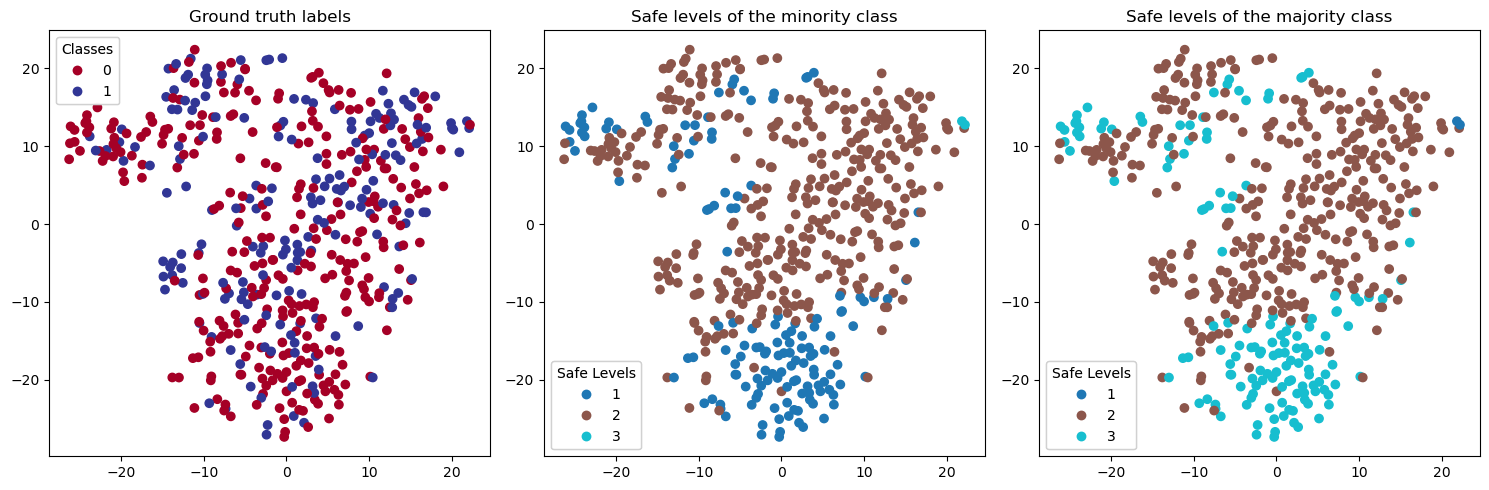

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot for ground truth labels
scatter_0 = ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, cmap='RdYlBu', label=y_plot)
ax[0].set_title('Ground truth labels')
legend1 = ax[0].legend(*scatter_0.legend_elements(), title="Classes")
ax[0].add_artist(legend1)

# Plot for safe levels of the minority class
scatter_1 = ax[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=safe_levels_minor, cmap='tab10', label=safe_levels_minor_plot)
ax[1].set_title('Safe levels of the minority class')
legend2 = ax[1].legend(*scatter_1.legend_elements(), title="Safe Levels")
ax[1].add_artist(legend2)

# Plot for safe levels of the majority class
scatter_2 = ax[2].scatter(X_embedded[:, 0], X_embedded[:, 1], c=safe_levels_major, cmap='tab10', label=safe_levels_major_plot)
ax[2].set_title('Safe levels of the majority class')
legend3 = ax[2].legend(*scatter_2.legend_elements(), title="Safe Levels")
ax[2].add_artist(legend3)

plt.tight_layout()
plt.show()
